# Femme au volant, mort au tournant ?

Question bien fâcheuse que celle de la mortalité des véhicules à roues. Plus particulièrement, des facteurs influençant ces risques. Est-il statistiquement plus probable qu'une femme soit victime un accident qu'un homme ? Est-il plus dangereux de conduire à Marseille qu'à Rennes ? Une conversion en motard est-elle une peine de mort autoinfligée ? Le but du projet est de pouvoir prédire la mortalité d'une situation en fonction de données connues par le conducteur. Ainsi, nous pourrions évaluer, par exemple, la dangerosité de la conduite d'une moto par une femme, aux alentours de Marseille, à deux heures du matin, au mois de Décembre.

Nous nous basons sur les données collectées par le *Ministère de l'Intérieur* sur l'année 2024, disponibles sur le site data.gouv à *[l'adresse suivante](https://www.data.gouv.fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024)*. Plus précisément, nous avons choisi les fichiers concernant respectivement les *types* de véhicules conduits (voiture, moto, etc), les caractéristiques spatio-temporelles des accidents, et les caractéristiques des conducteurs comme l'*âge* et le *sexe*. Comme nous le détaillerons plus loin, ces données s'avèrent propres, et ne nécessitent pas de travail de nettoyage.

Nous amorçons notre analyse par des visualisations, où nous pourrons constater quelques faits intéressants sur les accidents de la route. Ensuite, nous construirons et comparerons différents outils de prédiction de la gravité d'un potentiel accident. Nous commencerons par une **forêt aléatoire**, pour embrayer sur une **régression linéaire**, et conclure sur un **réseau neuronal**.

On commence par importer les librairies et les données

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df_c = pd.read_csv('https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115900/caract-2024.csv', encoding="utf-8", sep=';', engine='python')
df_i = pd.read_csv('https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251107-100210/2024.csv', encoding="utf-8", sep=';', engine='python')
df_u = pd.read_csv('https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115506/usagers-2024.csv', encoding="utf-8", sep=';', engine='python')

In [3]:
df_c.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202400000001,25,3,2024,07:40,2,70,70285,1,1,5,1,D438,"47,56277000","6,75832000"
1,202400000002,20,3,2024,15:05,1,21,21054,2,3,7,6,HOTEL DIEU (RUE DE L'),"47,02109000","4,83755000"
2,202400000003,22,3,2024,19:30,2,15,15012,1,1,1,6,Allée des Tilleuls,"44,90238400","2,49641800"
3,202400000004,24,3,2024,17:50,1,14,14118,2,3,7,3,128 Rue d'Authie,"49,19166000","-0,39851000"
4,202400000005,25,3,2024,19:35,5,13,13106,1,3,2,5,BEDOULE (CHEMIN DE LA),"43,39000000","5,35000000"


In [4]:
df_i.head()

,Id_accident,Lettre Conventionnelle Véhicule,Année,Lieu Admin Actuel - Territoire Nom,CNIT,Catégorie véhicule,Age véhicule
0,67 230 442,A,2024,Métropole,N10MCWCTMU3L706,VU,3.0
1,67 230 442,B,2024,Métropole,MRE3306AW885,VT,22.0
2,67 230 442,C,2024,Métropole,N10VWGCTN23U973,VT,7.0
3,67 230 443,A,2024,Métropole,LYM94J30J537,Moto lourde,14.0
4,67 230 444,A,2024,Métropole,WDF639603135376,VU,15.0


In [5]:
df_u.head(10)

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202400000001,203 988 581,155 781 758,A01,1,1,3,1,2003.0,2,1,-1,-1,-1,-1,-1
1,202400000001,203 988 582,155 781 759,B01,1,1,1,1,1997.0,4,1,-1,-1,-1,-1,-1
2,202400000002,203 988 579,155 781 757,A01,10,3,3,2,1927.0,5,0,-1,-1,3,3,1
3,202400000002,203 988 580,155 781 757,A01,1,1,1,1,1987.0,4,1,0,-1,3,3,1
4,202400000003,203 988 574,155 781 756,A01,2,2,4,2,2007.0,5,8,0,-1,-1,-1,-1
5,202400000003,203 988 575,155 781 756,A01,10,3,4,1,2007.0,5,0,-1,-1,6,B,3
6,202400000003,203 988 576,155 781 756,A01,10,3,3,2,2008.0,5,0,-1,-1,6,B,3
7,202400000003,203 988 577,155 781 756,A01,1,1,4,2,2007.0,5,8,0,-1,-1,-1,-1
8,202400000003,203 988 578,155 781 756,A01,10,3,1,1,2007.0,5,0,-1,-1,6,B,3
9,202400000004,203 988 573,155 781 754,B01,1,1,4,1,1963.0,5,2,6,-1,0,0,-1


## Visualisation

In [6]:
df_u_h = df_u[df_u["sexe"] == 1]
df_u_f = df_u[df_u["sexe"] == 2]
nb_h = df_u_h.shape[0]
nb_f = df_u_f.shape[0]
nb_u = nb_h + nb_f
# Attention aux unités : 1 accident, 1 véhicule ou 1 personne ?

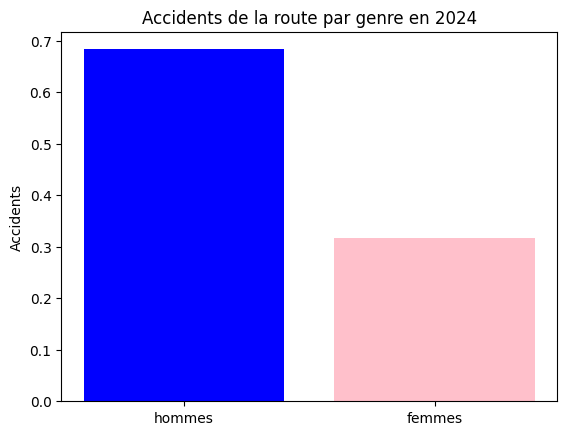

In [7]:
categories = ["hommes", "femmes"]
values = [nb_h / nb_u, nb_f / nb_u]
colors = ["blue", "pink"]

plt.ylabel("Accidents")
plt.title("Accidents de la route par genre en 2024")
plt.bar(categories, values, color=colors)
plt.show()


In [8]:
part_deces = df_u[df_u["grav"] == 4]["grav"].count() / nb_u
print(f"On a {part_deces * 100:.1f}% d'accidents de la route mortels en 2024.")

On a 40.5% d'accidents de la route mortels en 2024.


In [9]:
grav_moy = df_u["grav"].mean()
grav_moy_f = df_u_f["grav"].mean()
grav_moy_h = df_u_h["grav"].mean()

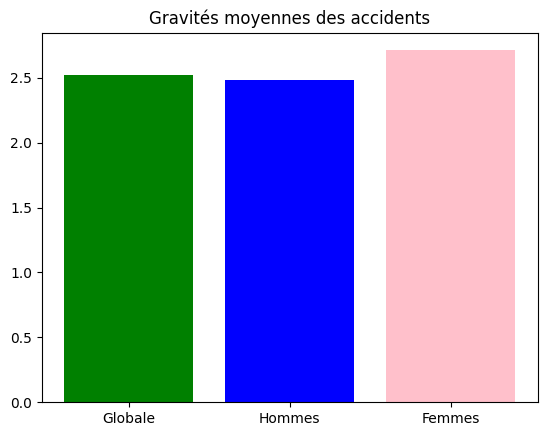

In [10]:
gravités = [grav_moy, grav_moy_h, grav_moy_f]
categories = ["Globale", "Hommes", "Femmes"]
couleurs = ["green", "blue", "pink"]

plt.bar(categories, gravités, color=couleurs)
plt.title("Gravités moyennes des accidents")
plt.show()
# Donner les écarts-types
# Sécurité moins adaptée pour les femmes ? Passagers et pas que les conducteurs.

On trouve déjà une information étonnante. Bien que les femmes soient victimes de deux fois moins d'accidents que les hommes, les accidents dont elles sont victimes sont, en moyenne, légèrement plus graves.

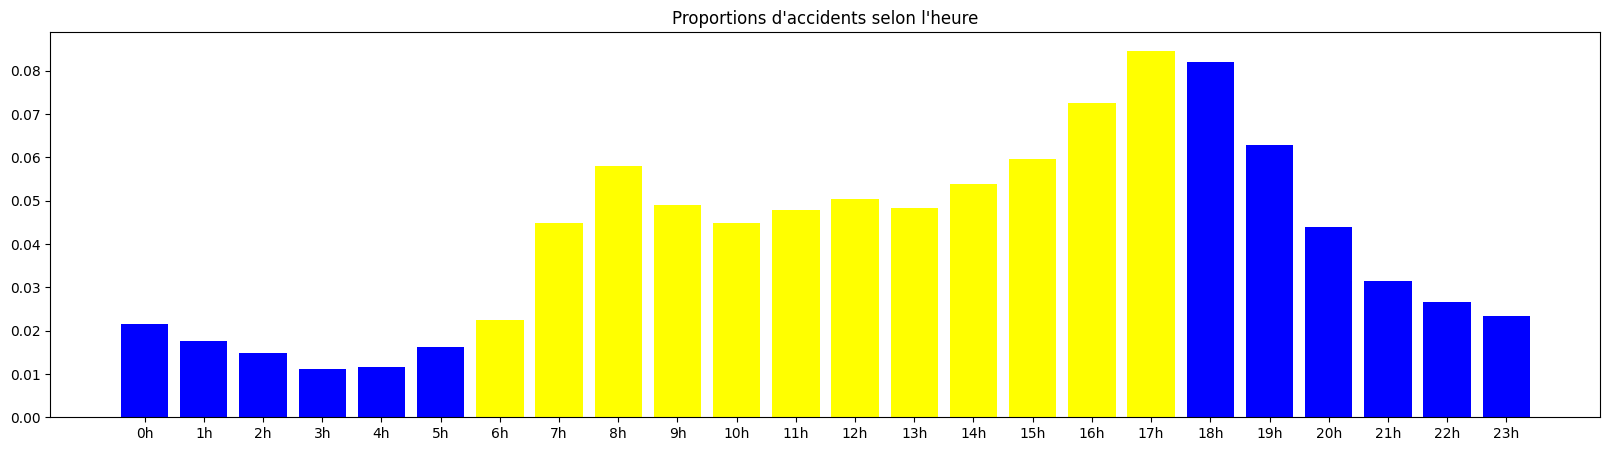

In [11]:
nb_c = df_c.count()
df_ratios_heures = df_c["hrmn"].apply(lambda s : int(s[:2])).value_counts(normalize=True)

heures = list(df_ratios_heures.sort_index())
categories = [str(k) + 'h' for k in range(24)]
couleurs = ["blue" for _ in range(6)] + ["yellow" for _ in range(12)] + ["blue" for _ in range(6)]

plt.figure(figsize=(20, 5))
plt.bar(categories, heures, color=couleurs)
plt.title("Proportions d'accidents selon l'heure")
plt.show()
# Voir s'il y a un rush hour en région ou pas

Deux phénomènes rentrent en jeu ici. D'une part, il y a très certainement beaucoup moins d'individus sur la route une fois la nuit tombée. Toutefois, ceux qui roulent à ces heures-là sont, à priori, plus en danger, et ce pour diverses raisons. On peut penser à une plus grande probabilité de conduire en étant fatigué ou ivre, ou tout simplement à cause de la visibilité réduite. 

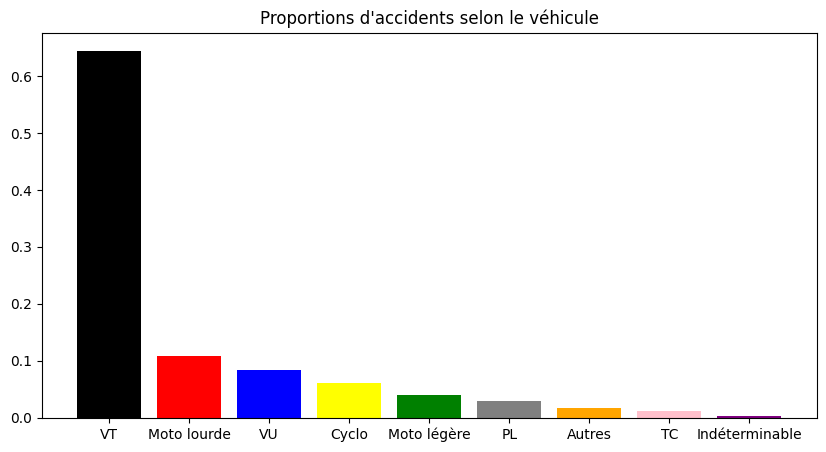

In [12]:
nb_i = df_i.count()
df_ratios_vehicules = df_i["Catégorie véhicule"].value_counts(normalize=True)

valeurs = list(df_ratios_vehicules)
categories = list(df_ratios_vehicules.index)
couleurs = ["black", "red", "blue", "yellow", "green", "gray", "orange", "pink", "purple"]

plt.figure(figsize=(10, 5))
plt.bar(categories, valeurs, color=couleurs)
plt.title("Proportions d'accidents selon le véhicule")
plt.show()
# Normaliser par rapport au nombre de véhicules de chaque type en circulation
# Relativiser par rapport au référencement et à la gravité des accidents ?

Sans grande surprise, comme les voitures sont de loin le véhicule le plus utilisé, elles représentent une écrasante majorité des accidents.

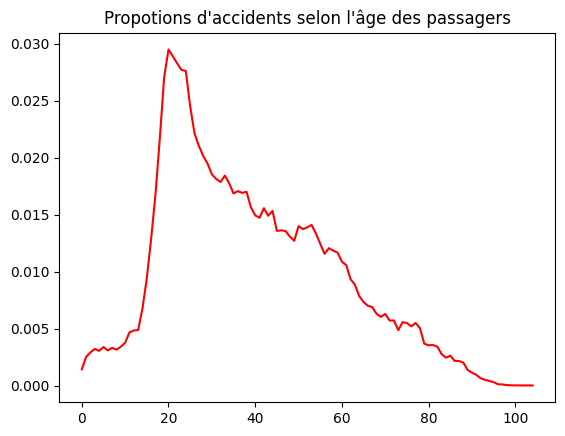

In [13]:
# Environ 2% des âges ne sont pas renseignés. Au vu de la petitesse de la valeur, nous avons d'éliminer ces lignes pour cette statistique.
df_ages = df_u["an_nais"].dropna().apply(lambda x : 2024 - int(x)).value_counts(normalize=True)
total = df_ages.count()
df_ages.sort_index()

plt.plot(list(df_ages.sort_index()), color='red')
plt.title("Propotions d'accidents selon l'âge des passagers")
plt.show()
#Corrélation entre gravité et âge.

On observe un pic de mortalité au début le vingtaine, et qui commence à se prononcer vers 15 et 16 ans, mais qui décroit brusquement vers la fin de la vingtaine, et suit une décroissance presque linéaire à partir de la trentaine. Ces observations paraissent raisonnables.

In [14]:
df_cu = pd.merge(df_c, df_u, on='Num_Acc', how='inner')
df_cu.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202400000001,25,3,2024,07:40,2,70,70285,1,1,...,3,1,2003.0,2,1,-1,-1,-1,-1,-1
1,202400000001,25,3,2024,07:40,2,70,70285,1,1,...,1,1,1997.0,4,1,-1,-1,-1,-1,-1
2,202400000002,20,3,2024,15:05,1,21,21054,2,3,...,3,2,1927.0,5,0,-1,-1,3,3,1
3,202400000002,20,3,2024,15:05,1,21,21054,2,3,...,1,1,1987.0,4,1,0,-1,3,3,1
4,202400000003,22,3,2024,19:30,2,15,15012,1,1,...,4,2,2007.0,5,8,0,-1,-1,-1,-1


In [15]:
df_grav_by_dep = df_cu.groupby('dep')['grav'].mean()
df_grav_by_dep.sort_values().head()

dep
986    2.000000
978    2.243590
40     2.288577
79     2.303665
18     2.335840
Name: grav, dtype: float64

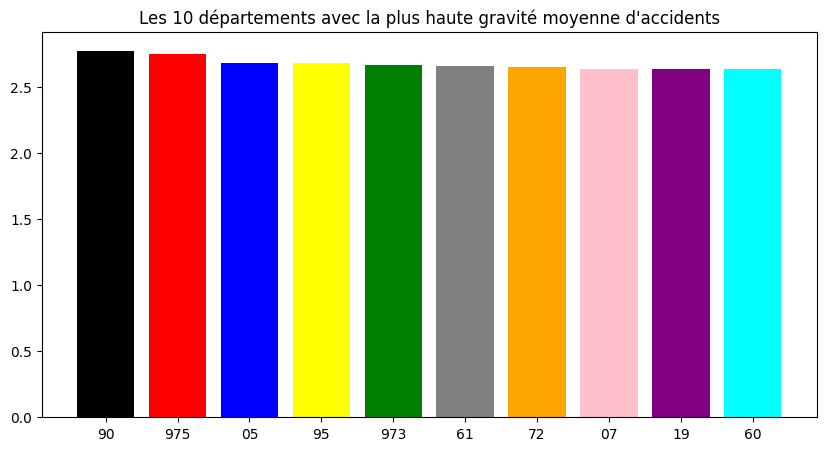

In [16]:
top_10 = df_grav_by_dep.sort_values(ascending = False)[:10]

plt.figure(figsize=(10, 5))
couleurs = ["black", "red", "blue", "yellow", "green", "gray", "orange", "pink", "purple", 'cyan']
plt.bar(top_10.index, top_10.values, color=couleurs)
plt.title("Les 10 départements avec la plus haute gravité moyenne d'accidents")
plt.show()

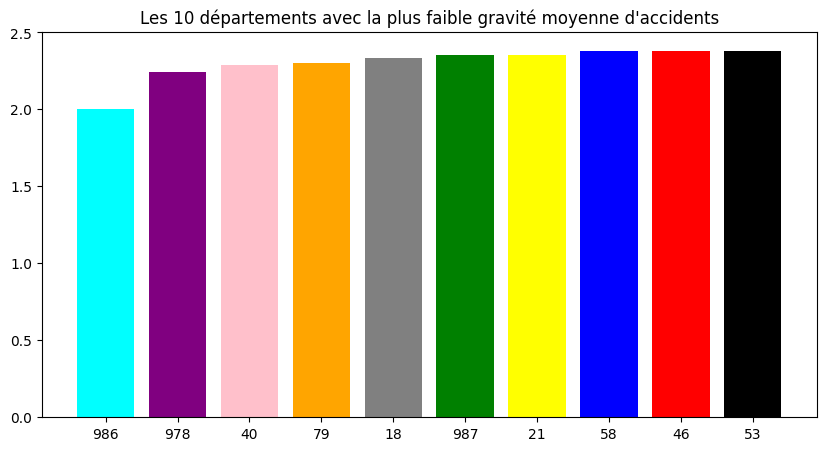

In [17]:
top_10 = df_grav_by_dep.sort_values(ascending = True)[:10]

plt.figure(figsize=(10, 5))
couleurs.reverse()
plt.bar(top_10.index, top_10.values, color=couleurs)
plt.title("Les 10 départements avec la plus faible gravité moyenne d'accidents")
plt.show()
# geopandas : carte avec les départements et heatmap
# plotly pour de jolis graphes
# Scikitlearn pour le réseau de neurones

In [18]:
df_tmp = df_cu[['dep', 'sexe']].copy()
df_tmp['sexe'] -= 1
df_f = df_tmp.groupby('dep')['sexe'].sum()
df_t = df_tmp.groupby('dep').count()
df_h = df_t - df_f
#df_h

## Prédiction

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

In [41]:
# Prédiction d'un accident à partir du genre, de l'âge et de l'heure 
df = pd.concat([df_cu["sexe"], df_cu["an_nais"].apply(lambda n : 2024 - n), df_cu["hrmn"].apply(lambda s : int(s[:2])), df_cu[["grav"]]], axis=1).dropna()
X, y = df[["sexe", "an_nais", "hrmn"]].rename(columns={"sexe" : "sexe", "an_nais" : "âge", "hrmn" : "heure"}), df["grav"]
X_train, X_test, y_train, y_test = train_test_split(X, y)
Classifier = MLPClassifier(max_iter=1000, random_state=42).fit(X_train, y_train)

In [47]:
y_pred = Classifier.predict(X_test)
score = accuracy_score(y_test, y_pred)
score

0.4679955630953935

Prédiction de mauvaise qualité, bien que meilleure qu'un choix aléatoire, qui aurait donné 20%.